# Вам предстоит решать задачу классификации изображений методом логистической регрессии. 

В итоге вы должны получить  функцию $f(x) \to [0,1]^{10}$, которая на вход получает картинку с написанной от руки цифрой, а на выход дает 10 вероятностей от 0 до 1 принадлежности к каждому из классов (цифре). Картинка это вектор из (8*8) = 64 чисел. Мы будем рассматривать параметрическое семейство функций $F(c)$, таких,  что если $f_с \in F$, то она удовлетворяет нашим требованиям. Кроме того, для каждой функции  $f_c \in F$ мы можем посчитать, насколько она хорошо работает на некотором наборе картинок - это будет функционал качества этой функции $loss(f_c, images)$. Чем он меньше, тем лучше: в идеале $loss$ будет давать $0$ в том случае, если наша функция на всех картинках, на которых нарисована цифра $i$ выдала вектор, где все числа отличны от $1$ и только на $i-м$ месте стоит $1$. Иначе это будет некоторое положительное число, которое тем больше, чем хуже работает классификатор (потеря)

Итак, возьмем функцию $g(c) = loss(f_c, images)$ и будем ее минимизировать. Если мы найдем глобальный минимум, то научимся максимально качественно решать задачу классификации с помощью того семейства функций, которое мы выбрали. Глобальный минимум мы, конечно, не сможем аналитически найти, поэтому будем решать задачу минимизации методом градиентного спуска.

# Возьмем датасет нарисованных от руки картинок

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

import math
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split

import tqdm

digits = load_digits()

/home/sharik/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
digits.data.shape

(1797, 64)

# Пример содержимого датасета

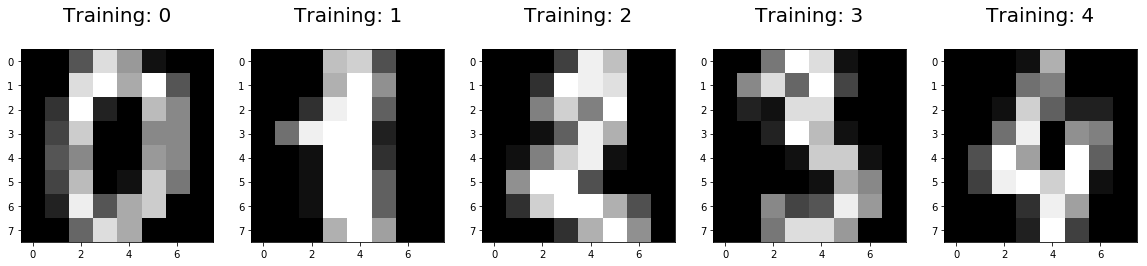

In [3]:
plt.figure(figsize=(20,4))

for index, (image, label) in enumerate(zip(digits.data[0:5], digits.target[0:5])):
    plt.subplot(1, 5, index+1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

# Разделим датасет на 2 части - train и validate
1. На первой мы будем решать оптимизационную задачу - искать такую функцию, которая по картинке выдает правильную цифру. 
2. На второй будем независимо проверять, насколько качественно работает наша функция

Это необходимо для того, чтобы понимать, насколько наша функция реально умеет решать поставленную задачу: понимать, где какая цифра. У нас ограниченная выборка - всего 1797 картинок. Но в реальности нарисованных цифр может быть значительно больше! Если даже наша функция безошибочно работает на всех 1797 картинках, но ошибается вне - это плохо. Обычно график обучения должен выглядит примерно так, если зеленое - обучающая выборка, а красное - валидационная

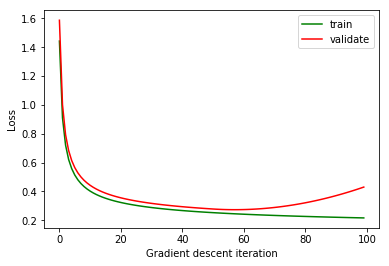

In [4]:
plt.plot(
    [1/math.log(i+2) for i in range(100)], 
    color='green', 
    label='train'
)

plt.plot(
    [1/math.log(i+2)*1.1+( (i/50.0-1)**2./5. if i>50 else 0.) for i in range(100)],
    color='red',
    label='validate')

plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

То есть с каждым шагом мы уменьшаем наш loss на обучающей выборке за счет градиентного спуска, но в какой-то момент функция может начать хорошо работать только на обучающей выборке. Этот эффект (в данном примере около 55 итерации по оси x) назвается переобучением.

# Вернемся к задаче
## Преобразуем числа от 0 до 9 в вектора из 10 элементов, где на i-m месте стоит 1, если цифра равна i и 0 иначе. 

## Также нормализуем картинки: все пиксели - это числа от 0 до 16. Сделаем их от -1 до 1, это улучшит качество нашей модели

In [5]:
def one_hot(y, n_classes):
    # делаем вектор из 10 координат с 0 везде кроме правильного ответа
    tmp = np.zeros(
        (len(y), n_classes), 
        dtype=np.uint8
    )
    tmp[range(len(tmp)), y] = 1
    return tmp

x_train, x_test, y_train, y_test = train_test_split(
    (digits.data-8)/16,
    one_hot(digits.target,10),
    test_size=0.33,
    random_state=0
)

# Задание: реализовать методом градиентного спуска логистическую регрессию. Начиная с этой ячейки и ниже разрешено использовать только стандартные функции  python и библиотеки numpy и  matplotlib

Для каждой картинки мы хотим найти вектор $(p_0,\ldots,p_{10})$, вероятностей, такой, что $p_i$ - вероятность того, что на картинка цифра $i$.

Реализуя логистическую регрессию, мы хотим приближать вероятности к их настоящему распределению. 

Выражение выдает ответ вида 
$$
W x + b
$$


где x - наш вектор картинки, а результат - числовой вектор размерности 10 с какими-то числами. Для того, чтобы эти числа стали вероятностями от 0 до 1, реализуем функцию 
$$
softmax(x) = \frac{e^x}{\sum(e^x)}
$$
и полученные значения будут как раз давать в сумме 1 и ими мы будем приближать вероятности. 

Оценивать качество нашей модели будем с помощью кросс-энтропии, см https://en.wikipedia.org/wiki/Cross_entropy 

# В данной точке x нужно научиться считать градиент. Выведите правила и посчитайте градиент в точке. Для того, чтобы выбирать градиент по всем точкам, можно его усреднить.

В приведённых выше терминах обозначим $SM_j = softmax(x_j) = \frac{e^{x_j}}{\sum_{k=1}^n (e^{x_k})}$ для некоторого вектора $x = (x_1, \dots, x_n)$. 

Для $i = j$ $\frac{\partial SM_i}{\partial x_j}
= \frac{\partial \frac{e^{x_i}}{\sum_{k=1}^{K} e^{x_k}}}{\partial x_j} 
= \frac{e^{x_i}\sum_{k=1}^{K} e^{x_k} - e^{x_j}e^{x_i}}{(\sum_{k=1}^{K} e^{x_k})^2} 
= \frac{e^{x_i}}{\sum_{k=1}^{K} e^{x_k}} \frac{\sum_{k=1}^{K} e^{x_k}-e^{x_j}}{\sum_{k=1}^{K} e^{x_k}} 
= SM_i(1-SM_j)$

Для $i \ne j$ $\frac{\partial SM_i}{\partial x_j}
= \frac{\partial \frac{e^{x_i}}{\sum_{k=1}^{K} e^{x_k}}}{\partial x_j}
= -\frac{0 - e^{x_j}e^{x_i}}{(\sum_{k=1}^{K} e^{x_k})^2} = 
\frac{e^{x_i}}{\sum_{k=1}^{K} e^{x_k}} \frac{e^{x_j}}{\sum_{k=1}^{K} e^{x_k}}
= -SM_iSM_j$

Нам сказали взять за функцию потерь кросс-энтропию, т. е. 
$loss(y_t, y_p) = - \sum\limits_{n=1}^N y_t(n) \ln(y_p(n))$, где $y_t$ --- настоящие значения вероятности (т. е., 0 или 1 в зависимости от истинного ответа на данном элементе выборки), а $y_p$ --- наши предсказанные вероятности, т. е. softmax.

Тогда у нас $\frac{\partial loss(W)}{\partial w_{ij}} = \sum_{n=1}^N \frac{\partial loss(W_i)}{\partial w_n} \frac{\partial\ softmax(W_n)}{\partial w_{ij}} 
= -\frac{1}{W_y}$

# Методом градиентного спуска с постоянным шагом минимизируйте loss на обучающей выборке.

In [147]:
from sklearn.metrics import log_loss
class LR:
    def get_Xn(self, X):
        return np.hstack((X, np.ones(X.shape[0]).reshape(-1,1)))
    
    def fit(self, X_train, Y_train, X_test, Y_test, itrs=5000, step=1000, report_cost=False, reg=0, 
            armijo=False, alpha=0.5, beta=0.5):
        Xn = self.get_Xn(X_train)
        
        self.reg=reg
        self.K = Y_train.shape[1]
        self.W = np.zeros((Y_train.shape[1], Xn.shape[1])) 
        #self.W = np.random.uniform(-0.1, 0.1, (Y_train.shape[1], Xn.shape[1]))
        
        train_loss = []
        test_loss = []
        for i in tqdm.tqdm_notebook(range(itrs)):
            grad = self.grad(Xn, Y_train, self.W)
            if armijo == True:
                s = self.armijo(self.W, X_train, Y_train, grad, step, alpha=alpha, beta=beta)
            self.W = self.W - s*grad
            
            if report_cost:
                train_loss.append(self.loss(X_train, Y_train))
                test_loss.append(self.loss(X_test, Y_test))
        
        return np.array(train_loss), np.array(test_loss)
    
    def softmax(self, W):
        """Вычисляет softmax от произвольной матрицы W"""
        # Чтобы при промежуточных операциях (суммировании e^z) не возникло переполнения, 
        # используем logsumexp, пытаясь сделать все операции с логарифмами, 
        # и только потом возвести e в степень.
        good = np.exp(W - sp.misc.logsumexp(W, axis=1).reshape(-1,1))
        # Впрочем, ни разу во время тестовых запусков следующий ассерт не сработал.
        #tmp = np.exp(W)
        #bad = tmp / np.sum(tmp, axis=1).reshape((-1,1))
        #assert((np.isclose(bad, good)).all())
            
        return good
    
    def predict(self, X, W=None):
        """Предсказывает значения по выборке. Возвращает вероятности принадлежности тому или иному классу"""
        if W is None:
            W = self.W
        Xn = self.get_Xn(X)
        return self.softmax(np.dot(Xn, W.T))
    
    def grad(self, Xn, Y, W):
        X = Xn[:, :-1]
        Yh = self.softmax(np.dot(Xn, W.T))
        gradient = np.dot(Yh.T-Y.T,Xn)/Xn.shape[0] + self.reg*W
        # Проверка градиента на правильность. Всё хорошо.
        #assert(sp.optimize.check_grad(lambda W: self.loss(X, Y, W=W.reshape(10, 65)), 
        #                            lambda W: np.dot(self.softmax(np.dot(Xn, W.reshape(10, 65).T)).T-Y.T,Xn).flatten()/Xn.shape[0], 
        #                            W.flatten()) < 1e-5)
        return gradient
    
    def armijo (self, W, X, Y, dW, s, alpha, beta):
        while True:
            deltaW = -dW
            f_new = self.loss(X, Y, W=(W+s*deltaW))
            f_old = self.loss(X, Y, W=(W))
            move = alpha*s*(deltaW*dW).sum()

            if f_new <= f_old+move:
                break
            s = beta*s

        #print('s=', s)
        return s
    
    def cross_entropy(self, Y_t, Y_p):
        return -np.sum(np.mean(Y_t*np.log(Y_p), axis=0), axis=0)
    
    def loss(self, X, Y, W=None):
        if W is None:
            W = self.W
        Y_p = self.predict(X, W=W)
        #print(log_loss(Y, Y_p), self.cross_entropy(Y, Y_p) - self.reg*np.trace(np.dot(W, W.T))/W.shape[0])
        #assert(np.isclose(log_loss(Y, Y_p), self.cross_entropy(Y, Y_p) - self.reg*np.trace(np.dot(W, W.T))/W.shape[0]))
        # Или +?
        return self.cross_entropy(Y, Y_p) - self.reg*np.trace(np.dot(W, W.T))/W.shape[0]
    

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))


Armijo = True
Error rate on train: 0.0
Error rate on test: 0.043771043771
Argmin loss on train: 4999
Argmin loss on test: 159


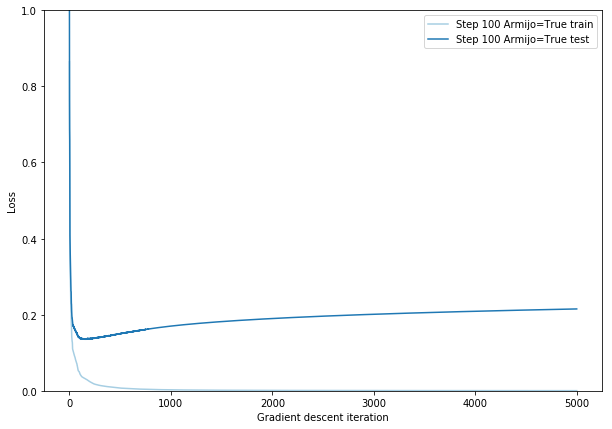

In [148]:
def error_rate(Yh, Y):
    return np.sum( np.not_equal(np.argmax(Yh,axis=1), np.argmax(Y,axis=1))) / float(Yh.shape[0]) 

lr = LR()

def run_and_report(armijo, itrs, step):
    loss_train, loss_test = lr.fit(x_train, y_train, x_test, y_test, report_cost=True, 
                                                 itrs=itrs, step=step, armijo=armijo, reg=0)
    print('Armijo =', armijo)
    print('Error rate on train:', error_rate(y_train, lr.predict(x_train)))
    print('Error rate on test:', error_rate(y_test, lr.predict(x_test)))
    
    cm = plt.cm.get_cmap('Paired')
    plt.plot(
        loss_train, 
        color=cm(plt.cmap_index),
        label='Step %d Armijo=%s train'%(step, armijo)
    )
    plt.cmap_index += 1
    
    plt.plot(
        loss_test,
        color=cm(plt.cmap_index),
        label='Step %d Armijo=%s test'%(step, armijo)
        )
    plt.cmap_index += 1

    plt.xlabel('Gradient descent iteration')
    plt.ylabel('Loss')
    plt.legend()
    
    print('Argmin loss on train:', np.argmin(loss_train))
    print('Argmin loss on test:', np.argmin(loss_test))
    
    return loss_train, loss_test

plt.figure(figsize=(10, 7))
plt.ylim(0, 1)
plt.cmap_index = 0
#loss_train, loss_test = run_and_report(False, 5000, 100)
loss_train_armijo, loss_test_armijo = run_and_report(True, 5000, 100)
#loss_train, loss_test = run_and_report(False, 5000, 1)
plt.show()

# Нарисуйте графики ошибки (loss) от номера шага градиентного спуска. Как падала ошибка на обучающей и тестовой выборках? На каком шаге ошибка на обучающей выборке оказалась минимальной?

# Реализуйте выбор шага градиентного спуска методом Армихо. Ускорило ли использование метода Армихо с начальными параметрами
$$ s=100, \beta=\alpha=0.5$$
# достижение минимума на обучающей выборке по сравнению с фиксированным шагом 100? А на валидационной?

# Какую долю картинок из валидационной выборки удается предсказать правильно? Приведите примеры из валидационной выборки, где модель ошибается и где работает правильно

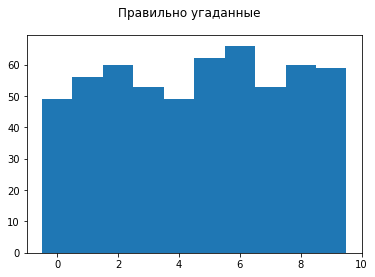

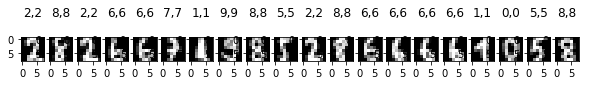

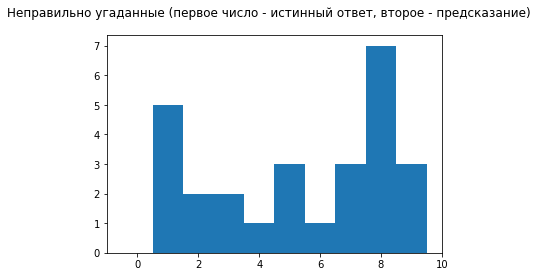

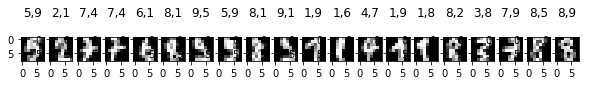

In [8]:
def draw_samples(n=5):
    y_pred = np.argmax(lr.predict(x_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    ans_mask = np.equal(y_pred, y_true)
    right_ans = np.argwhere(ans_mask).flatten()
    wrong_ans = np.argwhere(np.logical_not(ans_mask)).flatten()
    
    for indices, label in ((right_ans, 'Правильно угаданные'), 
                           (wrong_ans, 'Неправильно угаданные (первое число - истинный ответ, второе - предсказание)')): 
        plt.suptitle(label)
        bins = np.arange(-0.5, 10.5, 1)
        plt.hist(y_true[indices], bins=bins)
        plt.show()
        plt.figure(figsize=(10, 3))
        for i, (index) in enumerate(indices[:n]):
            image = x_test[index]
            plt.subplot(1, n, i+1)
            plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
            plt.title('%d,%d\n' % (y_true[index], y_pred[index]))
        plt.show()
draw_samples(20)